# Finding the most frequently occuring venues in 5 major districts of Tokyo

### Loading the Dataset

In [134]:
df_tokyo_wards = pd.read_csv('Tokyo_5_Wards.csv')

In [155]:
df_tokyo_wards.head()

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm)
0,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469,1703896
1,Chuo,14460,147620,Nihonbashi,35.684058,139.774501,2798951
2,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632,928783
3,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910,707708
4,Shibuya,15080,227850,Shibuya,35.664596,139.698711,1284956


In [137]:
df_tokyo_wards = df_tokyo_wards.drop('Unnamed: 0',axis=1)

In [156]:
df_tokyo_wards.head()

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm)
0,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469,1703896
1,Chuo,14460,147620,Nihonbashi,35.684058,139.774501,2798951
2,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632,928783
3,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910,707708
4,Shibuya,15080,227850,Shibuya,35.664596,139.698711,1284956


In [140]:
Tokyo_latitude = 35.6828387
Tokyo_longitude = 139.7594549

### Locating most busy office areas of Tokyo using latitude and longitude information

In [144]:
import folium
# create map of Most Busy Office Areas of Tokyo using latitude and longitude values
Tokyo_5Wards = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_tokyo_wards['Dist_Latitude'], df_tokyo_wards['Dist_Longitude'], 
                           df_tokyo_wards['Major_District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        color='magenta',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(Tokyo_5Wards)  
    
Tokyo_5Wards

### Clustering the Neighborhoods of the 5 most important wards in Tokyo

In [147]:
CLIENT_ID = 'LBK1TJ2Q5CCIPLHXF2GV2UT34DVYHTBLTKSO0Q1R2A1IVBMS' #'your-client-ID' # your Foursquare ID
CLIENT_SECRET = 'A0FFHAGMZIJ1WHKHCVQBQ3HWYWHMC5KKNHT2AXTYDCYBVRCL' #'your-client-secret' # your Foursquare Secret
VERSION = '20190325' # Foursquare API version

print('My credentails:')
print('My CLIENT_ID: ' + CLIENT_ID)
print('My CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
My CLIENT_ID: LBK1TJ2Q5CCIPLHXF2GV2UT34DVYHTBLTKSO0Q1R2A1IVBMS
My CLIENT_SECRET:A0FFHAGMZIJ1WHKHCVQBQ3HWYWHMC5KKNHT2AXTYDCYBVRCL


In [148]:
radius = 1000
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Dist_Latitude', 
                  'Dist_Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

In [149]:
Tokyo_5_Dist_Venues = getNearbyVenues(names=df_tokyo_wards['Major_District'],
                                   latitudes=df_tokyo_wards['Dist_Latitude'],
                                   longitudes=df_tokyo_wards['Dist_Longitude']
                                  )

Nagatacho
Nihonbashi
Shinjuku
Shinagawa
Shibuya


In [151]:
Tokyo_5_Dist_Venues.head()

,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
0,Nagatacho,35.675618,139.743469,Nagatacho Kurosawa (永田町 黒澤),35.674699,139.741737,Japanese Restaurant
1,Nagatacho,35.675618,139.743469,The Capitol Hotel Tokyu (ザ・キャピトルホテル東急),35.673927,139.741019,Hotel
2,Nagatacho,35.675618,139.743469,Star Hill (星ヶ岡),35.673953,139.740998,Chinese Restaurant
3,Nagatacho,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant
4,Nagatacho,35.675618,139.743469,Sushi Isshin (鮨 一新),35.672589,139.739399,Sushi Restaurant


In [152]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

Tokyo_5_Dist_Venues_only_restaurant = Tokyo_5_Dist_Venues[Tokyo_5_Dist_Venues['Venue_Category']\
                                                          .str.contains('Restaurant')].reset_index(drop=True)
Tokyo_5_Dist_Venues_only_restaurant.index = np.arange(1, len(Tokyo_5_Dist_Venues_only_restaurant)+1)
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Tokyo_5_Dist_Venues_only_restaurant.shape)
Tokyo_5_Dist_Venues_only_restaurant.head(3)

Shape of the Data-Frame with Venue Category only Restaurant:  (184, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
1,Nagatacho,35.675618,139.743469,Nagatacho Kurosawa (永田町 黒澤),35.674699,139.741737,Japanese Restaurant
2,Nagatacho,35.675618,139.743469,Star Hill (星ヶ岡),35.673953,139.740998,Chinese Restaurant
3,Nagatacho,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant


In [154]:

## Show in Map the Top Rated Restaruants in the Top 5 Districts

map_restaurants = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=11, tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the Venues based on the Major Districts
Districts = ['Nagatacho', 'Nihonbashi', 'Shinjuku', 'Shinagawa', 'Shibuya']

x = np.arange(len(Districts))

rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']

# add markers to the map
# markers_colors = []
for lat, lon, poi, distr in zip(Tokyo_5_Dist_Venues_only_restaurant['Venue_Lat'], 
                                  Tokyo_5_Dist_Venues_only_restaurant['Venue_Long'], 
                                  Tokyo_5_Dist_Venues_only_restaurant['Venue_Category'], 
                                  Tokyo_5_Dist_Venues_only_restaurant['District']):
    label = folium.Popup(str(poi) + ' ' + str(distr), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[Districts.index(distr)-1],
        fill=True,
        fill_color=rainbow[Districts.index(distr)-1],
        fill_opacity=0.3).add_to(map_restaurants)
       
map_restaurants

### Listing the top 10 categories of Restaurents in these areas

In [157]:
# create a dataframe of top 10 categories
Tokyo_5_Dist_Venues_Top10 = Tokyo_5_Dist_Venues['Venue_Category'].value_counts()[0:10].to_frame(name='frequency')
Tokyo_5_Dist_Venues_Top10=Tokyo_5_Dist_Venues_Top10.reset_index()
#Tokyo_5_Dist_Venues_Top10

Tokyo_5_Dist_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Tokyo_5_Dist_Venues_Top10

,Venue_Category,Frequency
0,Ramen Restaurant,25
1,Sake Bar,23
2,BBQ Joint,23
3,Japanese Restaurant,22
4,Café,19
5,Convenience Store,17
6,Bar,16
7,Chinese Restaurant,14
8,Hotel,14
9,Sushi Restaurant,13


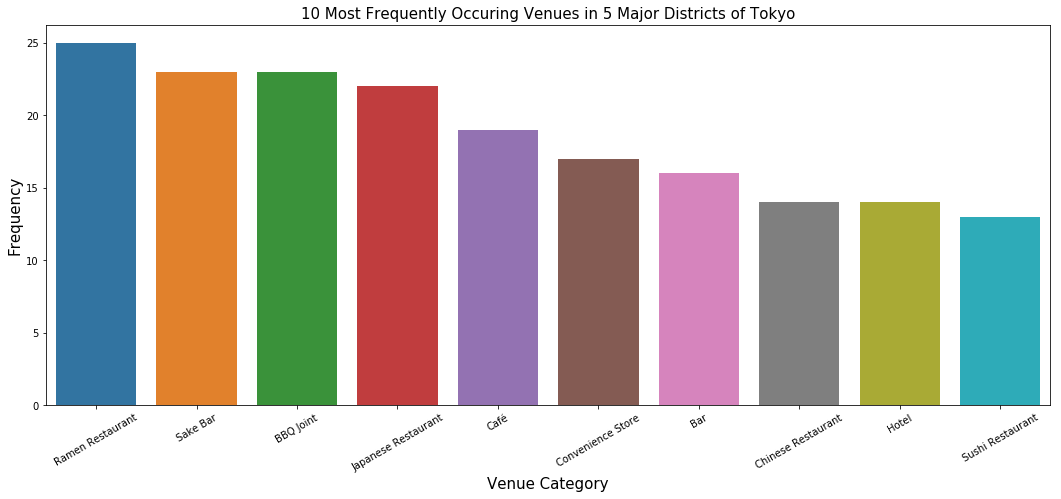

In [160]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Tokyo_5_Dist_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in 5 Major Districts of Tokyo', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

### Hence we have successfully obtained the 10 most frequently occuring venues in 5 major districts of Tokyo